# Exploring Consumer Sentiment & U.S. Housing Market Dynamics  

This Jupyter notebook downloads data from the **FRED API** to examine how the **University of Michigan Consumer Sentiment Index** relates to key U.S. housing‐market indicators:  

* **House prices** – S&P Case‑Shiller U.S. National Home Price Index  
* **Home sales** – New one‑family houses sold (SAAR)  
* **New construction** – Housing starts (SAAR)  
* **Interest rates** – Effective Fed Funds Rate & 10‑Year Treasury Yield  

We’ll:  
1. **Fetch & merge** these time‑series back to their earliest common date.  
2. **Visualize** the data and compare standardized trends.  
3. Compute **correlations & lag correlations** to see whether sentiment leads or lags housing metrics.  
4. (Optional) Run simple **regressions / Granger causality** tests.  

---

**Setup:**  
* Install the required Python packages (`fredapi`, `pandas`, `matplotlib`, `seaborn`, `statsmodels` if you want advanced time‑series tests).  
* Obtain a free FRED API key from <https://fred.stlouisfed.org/docs/api/api_key.html> and set it as an environment variable (`FRED_API_KEY`) *or* paste it directly in the code.  


In [1]:
# Uncomment the next line if you need to install the packages the first time
!pip install fredapi pandas matplotlib seaborn statsmodels --quiet



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fredapi import Fred

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')  # matplotlib ≥3.6
sns.set_context('talk')

# FRED API key – store in env var or paste manually
api_key = os.getenv('FRED_API_KEY', '3cc9b6492d820bb1d008b5c12778d72d')
if api_key.startswith('PASTE'):
    raise ValueError('Please set your FRED API key (env var FRED_API_KEY or paste in the string above).')

fred = Fred(api_key=api_key)


In [3]:
# FRED series codes
series_codes = {
    'Sentiment': 'UMCSENT',           # Consumer Sentiment Index (monthly, University of Michigan)
    'HousePriceIndex': 'CSUSHPINSA',  # S&P Case‑Shiller U.S. National Home Price Index (monthly, SA)
    'NewHomeSales_SAAR': 'HSN1F',     # New single‑family houses sold (monthly, seasonally adj., annual rate)
    'HousingStarts_SAAR': 'HOUST',    # Housing starts (monthly, SAAR)
    'FedFundsRate_%': 'FEDFUNDS',     # Effective Federal Funds Rate (monthly average, %)
    'TenYrYield_%': 'GS10'            # 10‑Year Treasury Constant Maturity Rate (monthly average, %)
}

# Retrieve each series into a dict of pandas Series
data_dict = {}
for name, code in series_codes.items():
    print(f'Downloading {name} ({code})...')
    data_dict[name] = fred.get_series(code)

# Combine into a single DataFrame aligned on the index (Date)
data = pd.DataFrame(data_dict)

# Remove rows with any NaNs (keeps the overlapping period of all series)
data.dropna(inplace=True)

print('Combined dataset shape:', data.shape)
data.head()


Combined dataset shape: (460, 6)


,Sentiment,HousePriceIndex,NewHomeSales_SAAR,HousingStarts_SAAR,FedFundsRate_%,TenYrYield_%
1987-01-01,90.4,63.733,709.0,1774.0,6.43,7.08
1987-02-01,90.2,64.132,732.0,1784.0,6.10,7.25
1987-03-01,90.8,64.468,713.0,1726.0,6.13,7.25
1987-04-01,92.8,64.973,735.0,1614.0,6.37,8.02
1987-05-01,91.1,65.547,651.0,1628.0,6.85,8.61


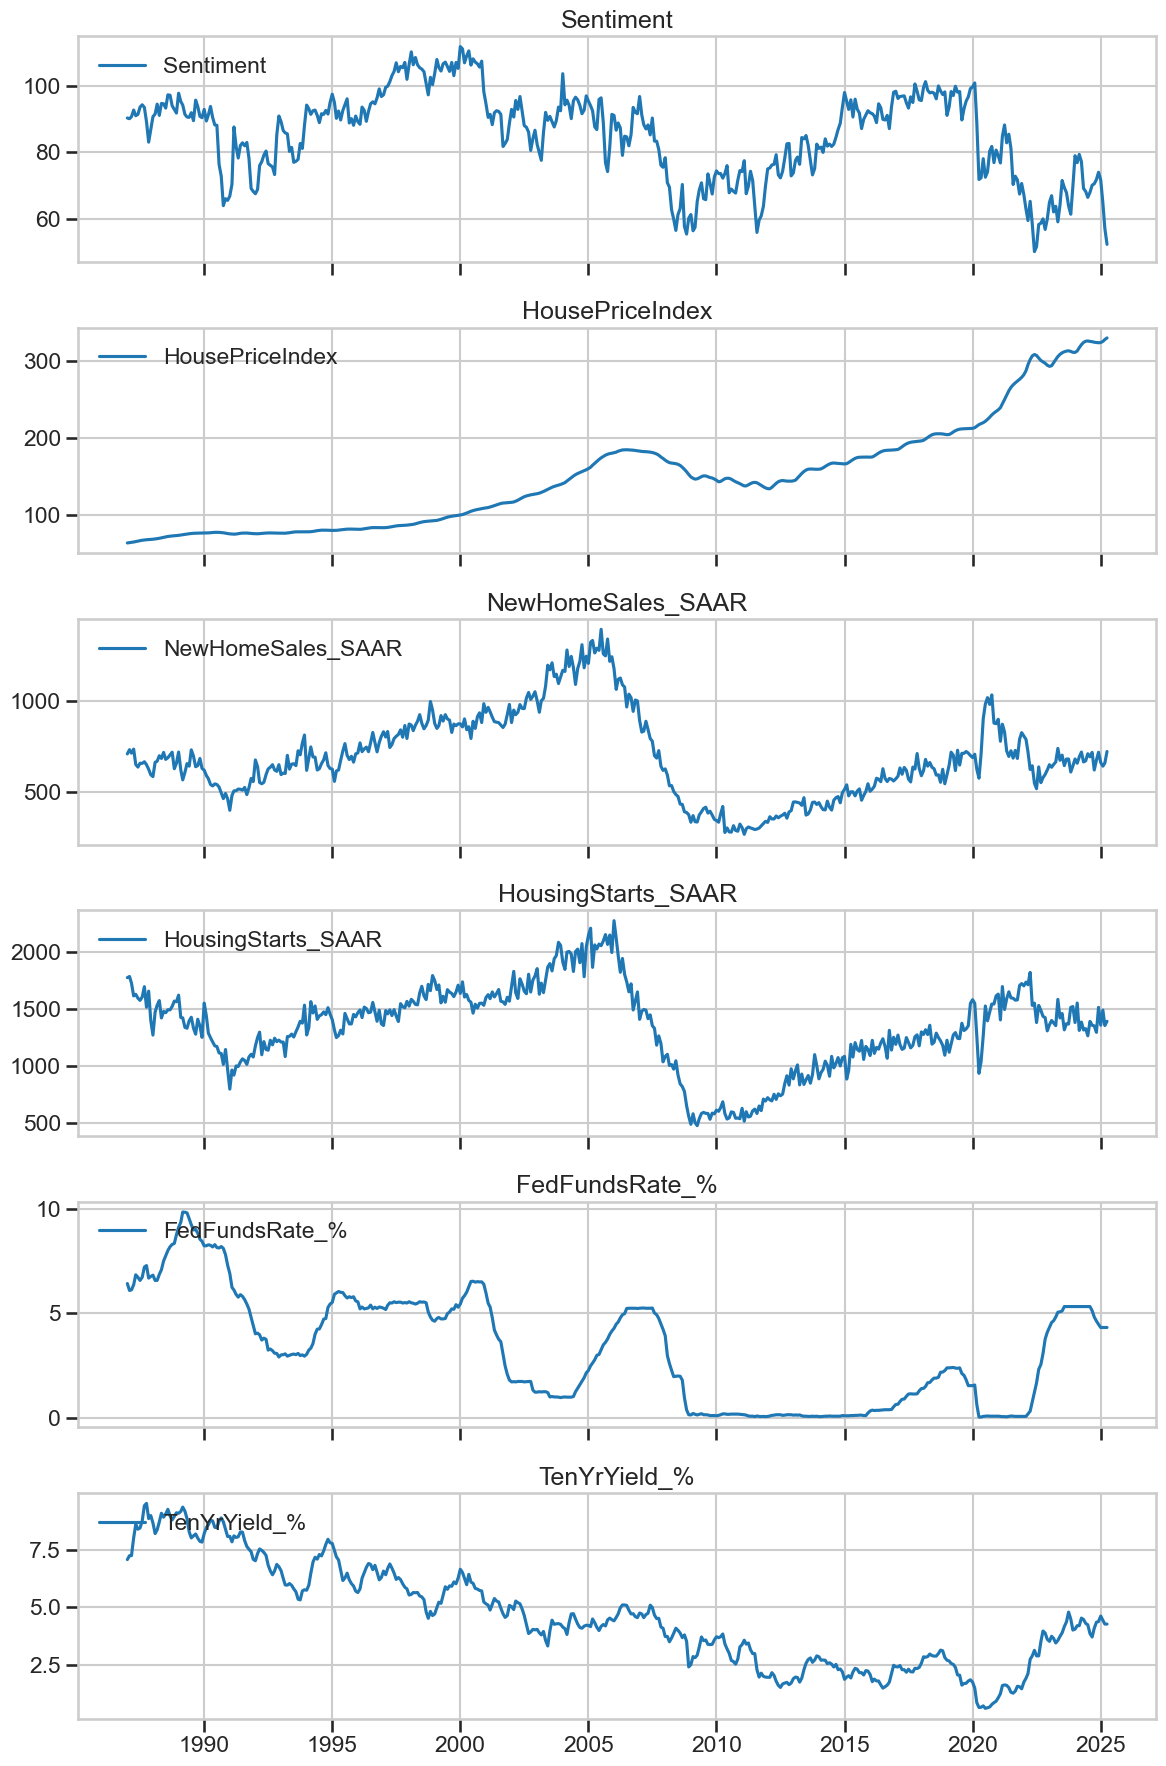

In [4]:
# Plot each series on its own axis for raw‑scale inspection
fig, axes = plt.subplots(len(data.columns), 1, figsize=(12, 18), sharex=True)
for ax, col in zip(axes, data.columns):
    ax.plot(data.index, data[col], label=col)
    ax.set_title(col)
    ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\aalrubai\PycharmProjects\capstone project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


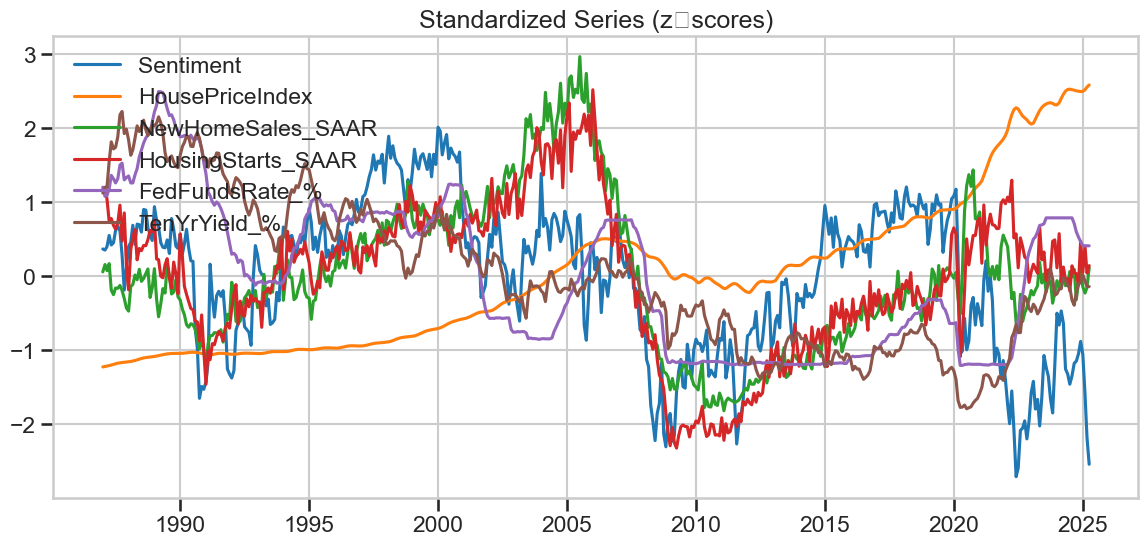

In [5]:
# Standardize (z‑score) to compare movements on same scale
data_std = (data - data.mean()) / data.std()

plt.figure(figsize=(14, 6))
for col in data_std.columns:
    plt.plot(data_std.index, data_std[col], label=col)
plt.title('Standardized Series (z‑scores)')
plt.legend(loc='upper left')
plt.show()


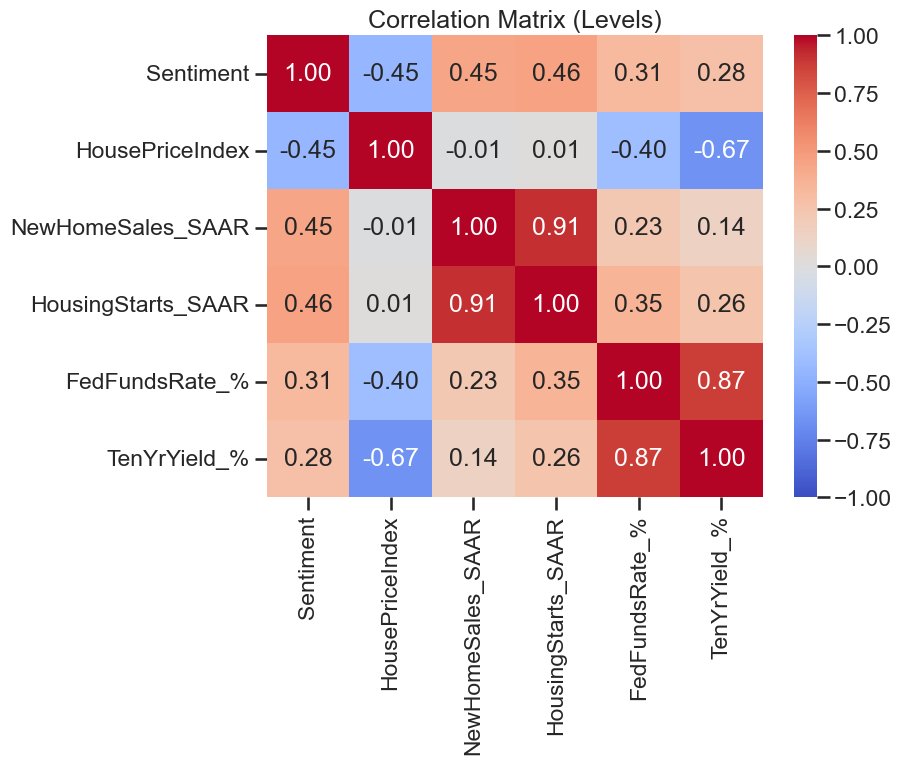

In [6]:
# Correlation matrix of levels
corr = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Levels)')
plt.show()


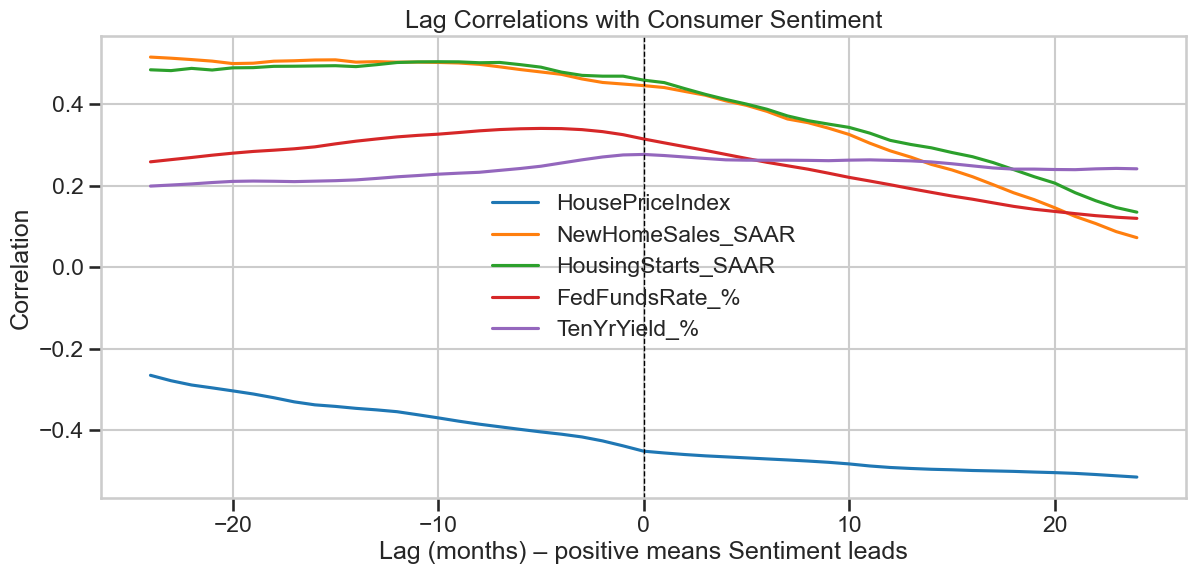

In [7]:
# Cross‑correlation of Sentiment vs. each housing variable at ±24‑month lags
max_lag = 24  # months
lags = range(-max_lag, max_lag + 1)
lag_results = {}

for col in data.columns:
    if col == 'Sentiment':
        continue
    lag_corrs = [data['Sentiment'].corr(data[col].shift(lag)) for lag in lags]
    lag_results[col] = lag_corrs

lag_df = pd.DataFrame(lag_results, index=lags)

# Plot
plt.figure(figsize=(14, 6))
for col in lag_df.columns:
    plt.plot(lag_df.index, lag_df[col], label=col)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title('Lag Correlations with Consumer Sentiment')
plt.xlabel('Lag (months) – positive means Sentiment leads')
plt.ylabel('Correlation')
plt.legend()
plt.show()


In [8]:
# OPTIONAL: Simple OLS regression – does Sentiment help explain YoY house‑price growth?
import statsmodels.api as sm

# Compute YoY % change in House Price Index
data['HPI_YoY'] = data['HousePriceIndex'].pct_change(12) * 100
data['Sentiment_Lag6'] = data['Sentiment'].shift(6)  # example 6‑month lead of sentiment

reg_df = data[['HPI_YoY', 'Sentiment_Lag6', 'FedFundsRate_%', 'TenYrYield_%']].dropna()
X = reg_df[['Sentiment_Lag6', 'FedFundsRate_%', 'TenYrYield_%']]
X = sm.add_constant(X)
y = reg_df['HPI_YoY']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                HPI_YoY   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     29.66
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           1.71e-17
Time:                        20:04:06   Log-Likelihood:                -1386.9
No. Observations:                 448   AIC:                             2782.
Df Residuals:                     444   BIC:                             2798.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -7.6712      1.856     -4.

### What should we do next?

| Problem / Curiosity | Easy fix or upgrade |
| --- | --- |
| **Serial correlation (DW ≈ 0)** | Re-run with **Newey-West / HAC** robust errors, or use `statsmodels.tsa.ARDL` / `statsmodels.tsa.DynamicOLS`, which allow autocorrelated errors. |
| **Only 17 % of variance explained** | Add more drivers: unemployment, real income, building permits, supply metrics, or include a **lag of `HPI_YoY`** itself (prices have “momentum”). |
| **Stationarity worries** | Work in **first differences** (month-over-month) or test for unit roots; consider a **VAR** so each series can affect the others dynamically. |
| **`FedFundsRate_%` looked weak** | Drop it (to avoid collinearity with the 10-year) or include **the spread** (10-year minus Fed-funds) instead, which analysts track. |
| **Check different lags** | We hard-coded a 6-month lag for sentiment. Use the lag-correlation plot to pick the best lead (maybe +3 or +9 months) or let an ARDL model search automatically. |

